# machine_temperature_system_failure

In [1]:
import csv
import datetime
import os
import numpy as np
import random
import math

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood 
#FIXME 代わりにTM.anomalyを使用しますが、 py.AnomalyLikelihoodよりも悪い結果になります
from htm.bindings.algorithms import Predictor

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

_INPUT_FILE_PATH ="machine_temperature_system_failure.csv"

In [2]:
# 入力ファイルの読み込み.
records = []
with open(_INPUT_FILE_PATH, "r") as fin:
    reader = csv.reader(fin)
    headers = next(reader)
    next(reader)
    next(reader)
    for record in reader:
      records.append(record)

print(len(records))

22693


In [3]:
 # エンコーダーを作成します。 これらは入力データをバイナリ表現に変換します.
dateEncoder = DateEncoder(timeOfDay= (30, 1)) 

scalarEncoderParams            = RDSE_Parameters()
scalarEncoderParams.size       = 700
scalarEncoderParams.sparsity   = 0.02
scalarEncoderParams.resolution = 0.88
scalarEncoder = RDSE( scalarEncoderParams )
encodingWidth = (dateEncoder.size + scalarEncoder.size)
enc_info = Metrics( [encodingWidth], 999999999 )

print("-"*100)
print("Encoded Input", enc_info)
print("-"*100)

----------------------------------------------------------------------------------------------------
Encoded Input SDR( 1420 )
    Sparsity Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
    Activation Frequency Min/Mean/Std/Max 1234.57 / 1234.59 / 0.0211179 / 1234.57
    Entropy 0
    Overlap Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
----------------------------------------------------------------------------------------------------


In [4]:
# HTMを作る。 SpatialPoolerとTemporalMemoryと関連ツール.
sp = SpatialPooler(
    inputDimensions            = (encodingWidth,),
    columnDimensions           = (1638,),
    potentialPct               = 0.85,
    potentialRadius            = encodingWidth,
    globalInhibition           = True,
    localAreaDensity           = 0.04395604395604396,
    synPermInactiveDec         = 0.006,
    synPermActiveInc           = 0.04,
    synPermConnected           = 0.13999999999999999,
    boostStrength              = 3.0,
    wrapAround                 = True
)
sp_info = Metrics( sp.getColumnDimensions(), 999999999 )

print("-"*100)
print("Spatial Pooler Mini-Columns", sp_info)
print("-"*100)
print(sp)
print("-"*100)

----------------------------------------------------------------------------------------------------
Spatial Pooler Mini-Columns SDR( 1638 )
    Sparsity Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
    Activation Frequency Min/Mean/Std/Max 1234.57 / 1234.59 / 0.0260008 / 1234.57
    Entropy 0
    Overlap Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
----------------------------------------------------------------------------------------------------
Spatial Pooler Connections:
    Inputs (1420) ~> Outputs (1638) via Segments (1638)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 1207 / 1207 / 1207
    Connected Synapses on Segment Min/Mean/Max 545 / 603.669 / 667
    Synapses Dead (1.5174e-06%) Saturated (1.0116e-06%)
    Synapses pruned (0%) Segments pruned (0%)

----------------------------------------------------------------------------------------------------


In [5]:
tm = TemporalMemory(
    columnDimensions          = (1638,), #sp.columnDimensions
    cellsPerColumn            = 13,
    activationThreshold       = 17,
    initialPermanence         = 0.21,
    connectedPermanence       = 0.13999999999999999, #sp.synPermConnected
    minThreshold              = 10,
    maxNewSynapseCount        = 32,
    permanenceIncrement       = 0.1,
    permanenceDecrement       = 0.1,
    predictedSegmentDecrement = 0.0,
    maxSegmentsPerCell        = 128,
    maxSynapsesPerSegment     = 64
)
tm_info = Metrics( [tm.numberOfCells()], 999999999 )

print("-"*100)
print("Temporal Memory Cells", tm_info)
print("-"*100)
print(tm)
print("-"*100)

----------------------------------------------------------------------------------------------------
Temporal Memory Cells SDR( 21294 )
    Sparsity Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
    Activation Frequency Min/Mean/Std/Max 1234.57 / 1234.49 / 0.08094 / 1234.57
    Entropy 0
    Overlap Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
----------------------------------------------------------------------------------------------------
Temporal Memory Connections:
    Inputs (0) ~> Outputs (21294) via Segments (0)
    Segments on Cell Min/Mean/Max 0 / 0 / 0
    Potential Synapses on Segment Min/Mean/Max 4294967295 / nan / 0
    Connected Synapses on Segment Min/Mean/Max 65535 / nan / 0
    Synapses Dead (nan%) Saturated (nan%)
    Synapses pruned (nan%) Segments pruned (nan%)

----------------------------------------------------------------------------------------------------


In [6]:
# セットアップ尤度（ゆうど）は、これらの設定が NAB
# これらの設定は、NABからコピーされます
probationaryPeriod = int(math.floor(float(0.1)*len(records)))
learningPeriod     = int(math.floor(probationaryPeriod / 2.0))
anomaly_history = AnomalyLikelihood(learningPeriod= learningPeriod,
                                  estimationSamples= probationaryPeriod - learningPeriod,
                                  reestimationPeriod= 100)

predictor = Predictor( steps=[1, 5], alpha=0.1)
predictor_resolution = 1

In [7]:
# データセット内のすべてのデータを反復処理し、入力と出力を記録します.
inputs      = []
anomaly     = []
anomalyProb = []
predictions = {1: [], 5: []}

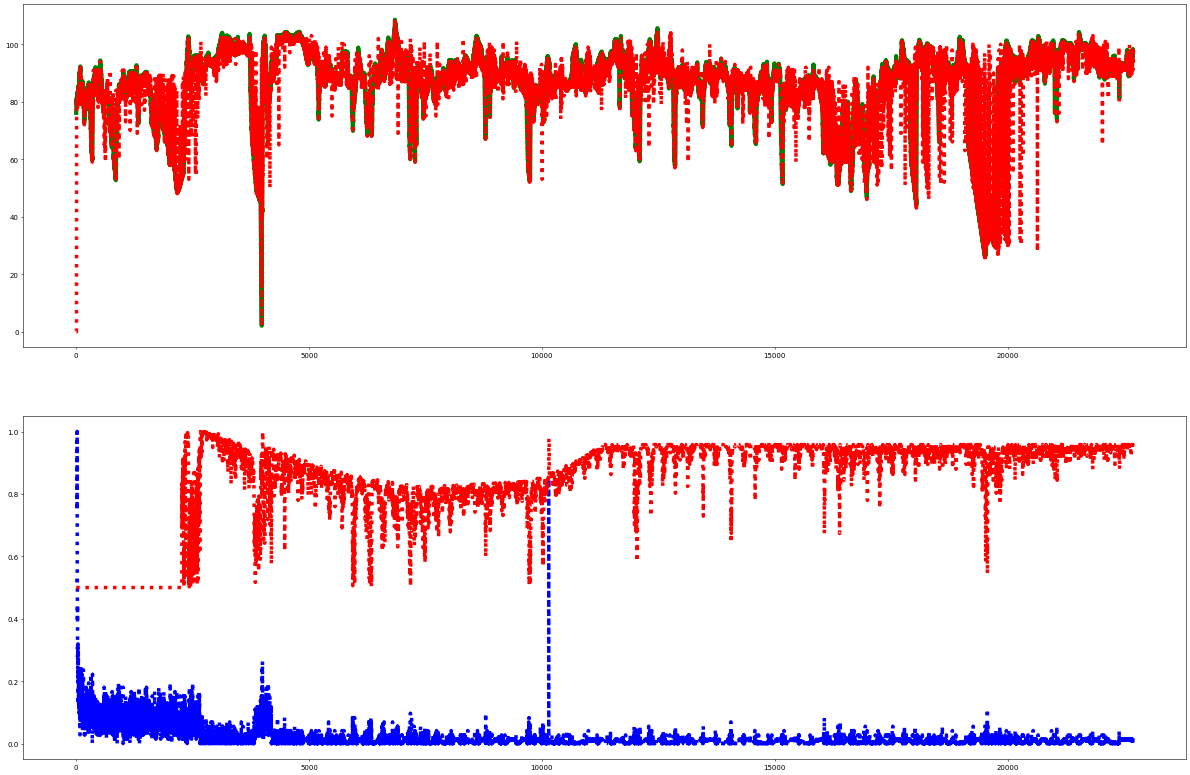

In [8]:
for count, record in enumerate(records):

    # 日付文字列をPythonの日付オブジェクトに変換する.
    dateString = datetime.datetime.strptime(record[0], "%Y-%m-%d %H:%M:%S")
    # データ値の文字列をfloatに変換.
    consumption = float(record[1])
    print(consumption)
    inputs.append( consumption )

    # エンコーダを呼び出して、各値のビット表現を作成します。 これらは SDR オブジェクトです.
    dateBits        = dateEncoder.encode(dateString)
    consumptionBits = scalarEncoder.encode(consumption)

    # これらのすべてのエンコーディングを 1 つの大きなエンコーディングに連結して、
    # 空間プーリング用に使用します.
    encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
    enc_info.addData( encoding )

    # これは、以下の計算方法で作成されます
    # Spatial Poolerと同じ寸法でなければなりません
    activeColumns = SDR( sp.getColumnDimensions() )

    # 入力空間に対する空間プーリングアルゴリズムの実行.
    sp.compute(encoding, True, activeColumns)
    sp_info.addData( activeColumns )

    # アクティブなミニカラムに対してTemporal Memoryアルゴリズムを実行する.
    tm.compute(activeColumns, learn=True)
    tm_info.addData( tm.getActiveCells().flatten() )

    # 何が起こるかを予測し、今起こったことに基づいて予測器を訓練する.
    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1,5):
        if pdf[n]:
            predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
        else:
            predictions[n].append(float('nan'))
        
    anomalyLikelihood = anomaly_history.anomalyProbability( consumption, tm.anomaly )
    
    anomaly.append( tm.anomaly )
    anomalyProb.append( anomalyLikelihood )

    predictor.learn(count, tm.getActiveCells(), int(consumption / predictor_resolution))
    
    clear_output(wait = True)
    plt.cla
    plot = plt.figure(figsize=(30,20),dpi=50)
    plt.subplot(2, 1, 1)
    plt.plot(inputs, color='green', linestyle = "solid", linewidth = 6.0)
    plt.plot(predictions[1], color='red', linestyle = "dotted", linewidth = 5.0)
    plt.subplot(2, 1, 2)
    plt.plot(anomaly, color='blue', linestyle = "dotted", linewidth = 5.0)
    plt.plot(anomalyProb, color='red', linestyle = "dotted", linewidth = 5.0)
    plt.show()